In [41]:
from xbpy.morgan import substructure_match, unique_index, morgan_prop
from xbpy.rdutil import read_molecules, position
from rdkit.Chem.rdmolops import RenumberAtoms
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
import numpy as np
import pymolviz as pmv
import matplotlib.pyplot as plt
from scipy.optimize import quadratic_assignment

In [42]:
#substructure_difficult = next(read_molecules("substructure_difficult_test.pdb"))
substructure_difficult = next(read_molecules("just_ring1.pdb"))
#xyz_file = next(read_molecules("new_reference.pdb"))
xyz_file = next(read_molecules("new_xyz.pdb"))
rdDetermineBonds.DetermineConnectivity(xyz_file)

In [43]:
xyz_file.GetSubstructMatch(substructure_difficult)

(3, 4, 5, 8, 7, 9, 11, 13, 14, 18, 19, 20)

In [3]:
mol1 = substructure_difficult
mol2 = xyz_file

In [4]:
from collections import deque

def convert_matrix_to_list(graph_matrix):
    adjacency_list = {}
    for i, row in enumerate(graph_matrix):
        adjacency_list[i] = [j for j, val in enumerate(row) if val == 1]
    return adjacency_list

def bfs_shortest_path(graph_list, start):
    distance = [-1 for vertex in graph_list]
    queue = deque([start])

    distance[start] = 0

    while queue:
        vertex = queue.popleft()
        for neighbor in graph_list[vertex]:
            if distance[neighbor] == -1:
                distance[neighbor] = distance[vertex] + 1
                queue.append(neighbor)
    
    return distance

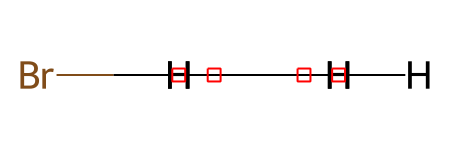

In [5]:
mol1

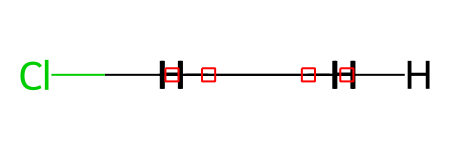

In [6]:
mol2

In [7]:
mol1_adj_list = convert_matrix_to_list(Chem.GetAdjacencyMatrix(mol1))
mol2_adj_list = convert_matrix_to_list(Chem.GetAdjacencyMatrix(mol2))

topological_distance_M_mol1 = np.array([bfs_shortest_path(mol1_adj_list, i) for i in range(mol1.GetNumAtoms())])
topological_distance_M_mol2 = np.array([bfs_shortest_path(mol2_adj_list, i) for i in range(mol2.GetNumAtoms())])


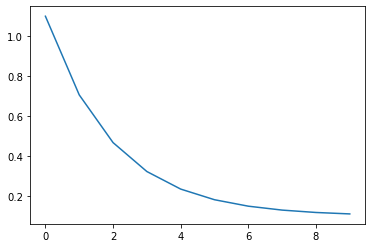

In [8]:
topological_distance_weight = lambda d: np.exp(-d * 5e-1) + .1
visualize_x = np.arange(0, 10, 1)
visualize_y = topological_distance_weight(visualize_x)
plt.plot(visualize_x, visualize_y)

In [9]:
weighted_topological_distance_M_mol1 = topological_distance_weight(topological_distance_M_mol1)
weighted_topological_distance_M_mol2 = topological_distance_weight(topological_distance_M_mol2)

In [10]:
topological_distance_M_mol1[topological_distance_M_mol1 == -1] = 6
topological_distance_M_mol2[topological_distance_M_mol2 == -1] = 6

In [39]:
cost_matrix = topological_distance_M_mol1.T @ topological_distance_M_mol2
assignment = quadratic_assignment(topological_distance_M_mol2, topological_distance_M_mol2, options= {"maximize":True}, method="2opt")

In [40]:
assignment

 col_ind: array([ 1,  0,  5,  4,  3,  2, 11, 10,  9,  8,  7,  6])
     fun: 1080
     nit: 449

In [38]:
permutation_matrix = np.zeros((mol1.GetNumAtoms(), mol2.GetNumAtoms()))
permutation_matrix[np.arange(mol1.GetNumAtoms()), assignment.col_ind] = 1

np.sum((weighted_topological_distance_M_mol1 - permutation_matrix @ weighted_topological_distance_M_mol2 @ permutation_matrix.T)**2)

10.837493155694947

In [ ]:
permutation_matrix @ topological_distance_M_mol1

array([[4., 3., 3., 2., 2., 1., 5., 4., 4., 3., 3., 0.],
       [3., 4., 2., 1., 3., 2., 4., 5., 3., 4., 0., 3.],
       [3., 2., 4., 3., 1., 2., 4., 3., 5., 0., 4., 3.],
       [2., 1., 3., 4., 2., 3., 3., 0., 4., 3., 5., 4.],
       [2., 3., 1., 2., 4., 3., 3., 4., 0., 5., 3., 4.],
       [1., 2., 2., 3., 3., 4., 0., 3., 3., 4., 4., 5.],
       [2., 3., 1., 0., 2., 1., 3., 4., 2., 3., 1., 2.],
       [0., 1., 1., 2., 2., 3., 1., 2., 2., 3., 3., 4.],
       [3., 2., 2., 1., 1., 0., 4., 3., 3., 2., 2., 1.],
       [1., 2., 0., 1., 3., 2., 2., 3., 1., 4., 2., 3.],
       [1., 0., 2., 3., 1., 2., 2., 1., 3., 2., 4., 3.],
       [2., 1., 3., 2., 0., 1., 3., 2., 4., 1., 3., 2.]])

In [16]:
my_assignment = [4, 1, 5, 2, 0, 3, 6, 9, 7, 8, 10, 11]
permutation_matrix = np.zeros((mol1.GetNumAtoms(), mol2.GetNumAtoms()))
permutation_matrix[np.arange(mol1.GetNumAtoms()), my_assignment] = 1

np.sum((permutation_matrix.T @ topological_distance_M_mol1 @ permutation_matrix - topological_distance_M_mol2)**2)

0.0

In [ ]:
permutation_matrix @ topological_distance_M_mol1 @ permutation_matrix.T

array([[0., 1., 1., 3., 2., 2., 3., 1., 2., 4., 3., 2.],
       [1., 0., 2., 2., 1., 3., 2., 2., 1., 3., 4., 3.],
       [1., 2., 0., 2., 3., 1., 4., 2., 3., 3., 2., 1.],
       [3., 2., 2., 0., 1., 1., 2., 4., 3., 1., 2., 3.],
       [2., 1., 3., 1., 0., 2., 1., 3., 2., 2., 3., 4.],
       [2., 3., 1., 1., 2., 0., 3., 3., 4., 2., 1., 2.],
       [3., 2., 4., 2., 1., 3., 0., 4., 3., 3., 4., 5.],
       [1., 2., 2., 4., 3., 3., 4., 0., 3., 5., 4., 3.],
       [2., 1., 3., 3., 2., 4., 3., 3., 0., 4., 5., 4.],
       [4., 3., 3., 1., 2., 2., 3., 5., 4., 0., 3., 4.],
       [3., 4., 2., 2., 3., 1., 4., 4., 5., 3., 0., 3.],
       [2., 3., 1., 3., 4., 2., 5., 3., 4., 4., 3., 0.]])

In [ ]:
topological_distance_M_mol1

array([[0, 1, 1, 2, 2, 3, 1, 2, 2, 3, 3, 4],
       [1, 0, 2, 3, 1, 2, 2, 1, 3, 2, 4, 3],
       [1, 2, 0, 1, 3, 2, 2, 3, 1, 4, 2, 3],
       [2, 3, 1, 0, 2, 1, 3, 4, 2, 3, 1, 2],
       [2, 1, 3, 2, 0, 1, 3, 2, 4, 1, 3, 2],
       [3, 2, 2, 1, 1, 0, 4, 3, 3, 2, 2, 1],
       [1, 2, 2, 3, 3, 4, 0, 3, 3, 4, 4, 5],
       [2, 1, 3, 4, 2, 3, 3, 0, 4, 3, 5, 4],
       [2, 3, 1, 2, 4, 3, 3, 4, 0, 5, 3, 4],
       [3, 2, 4, 3, 1, 2, 4, 3, 5, 0, 4, 3],
       [3, 4, 2, 1, 3, 2, 4, 5, 3, 4, 0, 3],
       [4, 3, 3, 2, 2, 1, 5, 4, 4, 3, 3, 0]])

In [ ]:
topological_distance_M_mol2

array([[0, 1, 2, 1, 2, 3, 3, 4, 1, 2, 3, 2],
       [1, 0, 3, 2, 1, 2, 2, 3, 2, 1, 4, 3],
       [2, 3, 0, 1, 2, 1, 3, 2, 3, 4, 1, 2],
       [1, 2, 1, 0, 3, 2, 4, 3, 2, 3, 2, 1],
       [2, 1, 2, 3, 0, 1, 1, 2, 3, 2, 3, 4],
       [3, 2, 1, 2, 1, 0, 2, 1, 4, 3, 2, 3],
       [3, 2, 3, 4, 1, 2, 0, 3, 4, 3, 4, 5],
       [4, 3, 2, 3, 2, 1, 3, 0, 5, 4, 3, 4],
       [1, 2, 3, 2, 3, 4, 4, 5, 0, 3, 4, 3],
       [2, 1, 4, 3, 2, 3, 3, 4, 3, 0, 5, 4],
       [3, 4, 1, 2, 3, 2, 4, 3, 4, 5, 0, 3],
       [2, 3, 2, 1, 4, 3, 5, 4, 3, 4, 3, 0]])

In [ ]:
reordering = np.arange(mol1.GetNumAtoms()) @ permutation_matrix

In [ ]:
atom_symbols1 = np.array([a.GetSymbol() for a in mol1.GetAtoms()])
atom_symbols2 = np.array([a.GetSymbol() for a in mol2.GetAtoms()])
reordered_atom_symbols2 =  atom_symbols1[reordering]

print(atom_symbols2)
print(reordered_atom_symbols2)


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
new_indices = np.arange(mol2.GetNumAtoms()) @ permutation_matrix

In [ ]:
new_indices

array([15,  5, 11, 12,  9,  8,  6,  7, 13, 14, 10, 23,  2, 18,  1, 19, 16,
       17,  0,  4, 20, 21,  3, 22])

In [ ]:
new_mol2 = Chem.RenumberAtoms(mol2, new_indices.tolist())
Chem.MolToPDBFile(new_mol2, "reordered_xyz.pdb")